<h2>Урок 6<h2/>

<p>1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?<p/>

<p>3. *Сделайте свою реализацию U-Net на TensorFlow<p/>

Взят датасет https://www.kaggle.com/bulentsiyah/semantic-drone-dataset 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0-dev20210702


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, Average, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image

# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [3]:
import pandas as pd

In [4]:
import cv2

In [5]:
class_segment = pd.read_csv('./data/class_dict_seg.csv')
class_segment

,name,r,g,b
0,без маркировки,0,0,0
1,асфальт,128,64,128
2,грязь,130,76,0
3,трава,0,102,0
4,гравий,112,103,87
5,вода,28,42,168
6,камни,48,41,30
7,бассейн,0,50,89
8,растительность,107,142,35
9,крыша,70,70,70


In [6]:
class_segment[class_segment.columns[1:]].values

array([[  0,   0,   0],
       [128,  64, 128],
       [130,  76,   0],
       [  0, 102,   0],
       [112, 103,  87],
       [ 28,  42, 168],
       [ 48,  41,  30],
       [  0,  50,  89],
       [107, 142,  35],
       [ 70,  70,  70],
       [102, 102, 156],
       [254, 228,  12],
       [254, 148,  12],
       [190, 153, 153],
       [153, 153, 153],
       [255,  22,  96]], dtype=int64)

In [7]:
PAHT_label = 'D:\Git\GB-NN\Lesson_6\data\RGB_color_image_masks\RGB_color_image_masks\\'

PAHT_image = 'D:\Git\GB-NN\Lesson_6\data\dataset\semantic_drone_dataset\original_images\\'

In [8]:
import os, fnmatch
imag = os.listdir(PAHT_image)
imag_label = os.listdir(PAHT_label)

In [9]:
imag

['000.jpg',
 '001.jpg',
 '002.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '008.jpg',
 '011.jpg',
 '013.jpg',
 '014.jpg',
 '015.jpg',
 '016.jpg',
 '018.jpg',
 '019.jpg',
 '021.jpg',
 '022.jpg',
 '023.jpg',
 '026.jpg',
 '028.jpg',
 '031.jpg',
 '035.jpg',
 '038.jpg',
 '040.jpg',
 '041.jpg',
 '042.jpg',
 '043.jpg',
 '044.jpg',
 '045.jpg',
 '047.jpg',
 '049.jpg',
 '051.jpg',
 '052.jpg',
 '053.jpg',
 '055.jpg',
 '056.jpg',
 '057.jpg',
 '058.jpg',
 '059.jpg',
 '060.jpg',
 '062.jpg',
 '063.jpg',
 '065.jpg',
 '068.jpg',
 '070.jpg',
 '071.jpg',
 '073.jpg',
 '074.jpg',
 '075.jpg',
 '077.jpg',
 '078.jpg',
 '079.jpg',
 '080.jpg',
 '081.jpg',
 '083.jpg',
 '086.jpg',
 '088.jpg',
 '089.jpg',
 '092.jpg',
 '095.jpg',
 '098.jpg',
 '099.jpg',
 '100.jpg',
 '101.jpg',
 '102.jpg',
 '103.jpg',
 '104.jpg',
 '106.jpg',
 '107.jpg',
 '109.jpg',
 '110.jpg',
 '111.jpg',
 '112.jpg',
 '113.jpg',
 '116.jpg',
 '117.jpg',
 '118.jpg',
 '119.jpg',
 '120.jpg',
 '121.jpg',
 '122.jpg',
 '123.jpg',
 '124.jpg',
 '12

In [10]:
imag_label

['000.png',
 '001.png',
 '002.png',
 '003.png',
 '004.png',
 '005.png',
 '006.png',
 '008.png',
 '011.png',
 '013.png',
 '014.png',
 '015.png',
 '016.png',
 '018.png',
 '019.png',
 '021.png',
 '022.png',
 '023.png',
 '026.png',
 '028.png',
 '031.png',
 '035.png',
 '038.png',
 '040.png',
 '041.png',
 '042.png',
 '043.png',
 '044.png',
 '045.png',
 '047.png',
 '049.png',
 '051.png',
 '052.png',
 '053.png',
 '055.png',
 '056.png',
 '057.png',
 '058.png',
 '059.png',
 '060.png',
 '062.png',
 '063.png',
 '065.png',
 '068.png',
 '070.png',
 '071.png',
 '073.png',
 '074.png',
 '075.png',
 '077.png',
 '078.png',
 '079.png',
 '080.png',
 '081.png',
 '083.png',
 '086.png',
 '088.png',
 '089.png',
 '092.png',
 '095.png',
 '098.png',
 '099.png',
 '100.png',
 '101.png',
 '102.png',
 '103.png',
 '104.png',
 '106.png',
 '107.png',
 '109.png',
 '110.png',
 '111.png',
 '112.png',
 '113.png',
 '116.png',
 '117.png',
 '118.png',
 '119.png',
 '120.png',
 '121.png',
 '122.png',
 '123.png',
 '124.png',
 '12

In [11]:
h1 = 200
w1 = 400

In [12]:
images = []
segments = []
image_size = (h1,w1)
for i_name in imag[:150]:
    images.append(image.load_img(PAHT_image + i_name ,target_size=image_size))
    segments.append(image.load_img(PAHT_label + i_name.split('.')[0] + '.png', target_size=image_size))

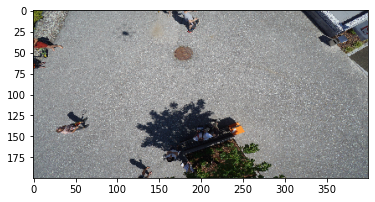

In [13]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

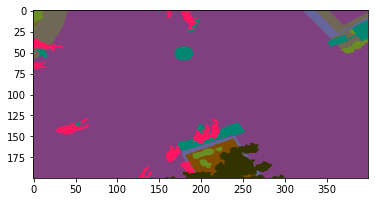

In [14]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

In [15]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)
#xTrain_Test = xTrain_Test[:200]

In [16]:
print(xTrain_Test.shape)

(150, 200, 400, 3)


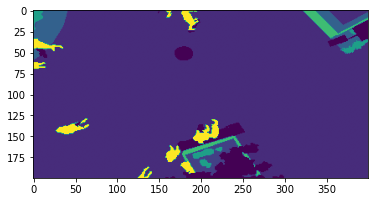

In [17]:
def Color2index(y):
    arr_col=class_segment[class_segment.columns[1:]].values
    y_ind = np.zeros((y.shape[0],y.shape[1]))
    y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
        y_ind[ind_i[0],ind_i[1]] = i
        y_cat[ind_i[0],ind_i[1], i-1] = 1 
        i += 1
  
    return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  

In [18]:
np.sum(cat_yi[100:,:100,1] )

9681.0

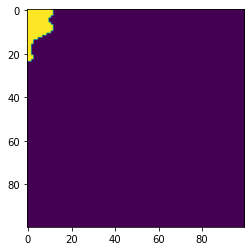

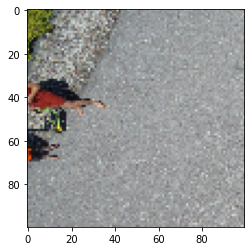

In [19]:
plt.imshow(cat_yi[:100,:100,8])
plt.show()
plt.imshow(xTrain_Test[0,:100,:100,:]/255)
plt.show()

In [20]:
cat_yi.shape

(200, 400, 16)

In [21]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)
#yTrain_Test = yTrain_Test[:200]

In [22]:
print(yTrain_Test.shape)

(150, 200, 400, 16)


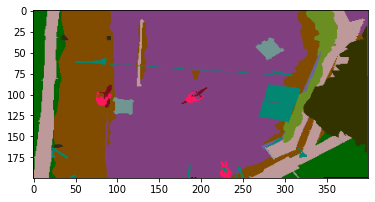

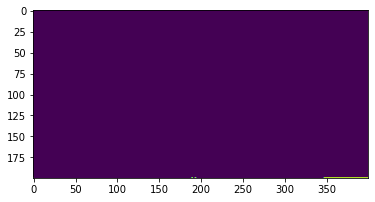

In [23]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

In [24]:
#del images
#del segments

In [25]:
xTrain_Test.shape

(150, 200, 400, 3)

In [26]:
N = int(yTrain_Test.shape[0] - yTrain_Test.shape[0]*0.2)
N

120

In [27]:
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [28]:
xTest.shape

(30, 200, 400, 3)

In [29]:
del yTrain_Test
del xTrain_Test

In [30]:
yTest.shape

(30, 200, 400, 16)

In [31]:
print(xTrain.shape)
print(yTrain.shape)

(120, 200, 400, 3)
(120, 200, 400, 16)


In [32]:
from tensorflow.keras.utils import plot_model

In [33]:
def Unet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x200

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x100

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x50

    # Block 4
    x = Conv2D(1024, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1024, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    xblock_2_out = Conv2D(64, (3, 3), padding='same')(block_2_out)
    xblock_2_out = BatchNormalization()(xblock_2_out)
    xblock_2_out = Activation('relu')(xblock_2_out)
    xblock_2_out = Conv2D(128, (3, 3), padding='same')(xblock_2_out)
    xblock_2_out = BatchNormalization()(xblock_2_out)
    xblock_2_out = Activation('relu')(xblock_2_out)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out, xblock_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    xblock_1_out = Conv2D(64, (3, 3), padding='same')(block_1_out)
    xblock_1_out = BatchNormalization()(xblock_1_out)
    xblock_1_out = Activation('tanh')(xblock_1_out)
    xblock_1_out = Conv2D(64, (3, 3), padding='same')(xblock_1_out)
    xblock_1_out = BatchNormalization()(xblock_1_out)
    xblock_1_out = Activation('tanh')(xblock_1_out)
    xblock_1_out = Conv2D(64, (3, 3), padding='same')(xblock_1_out)
    xblock_1_out = BatchNormalization()(xblock_1_out)
    xblock_1_out = Activation('relu')(xblock_1_out)
    xblock_1_out = Conv2D(64, (3, 3), padding='same')(xblock_1_out)
    xblock_1_out = BatchNormalization()(xblock_1_out)
    xblock_1_out = Activation('relu')(xblock_1_out)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out, xblock_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [34]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'D:\Git\GB-NN\Lesson_6\modelUnet.mdw',
    monitor="val_dice_coef",
    save_best_only=True,
    save_weights_only=True,
)

In [35]:
modelC = Unet(class_segment[class_segment.columns[1:]].values.shape[0], (h1, w1, 3))

plot_model(modelC, to_file='modelC.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 400, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 400, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 400, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 200, 400, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [36]:
xTrain.shape

(120, 200, 400, 3)

In [37]:
xtr = xTrain[:100]
ytr = yTrain[:100]

In [38]:
xval = xTrain[100:]
yval = yTrain[100:]

In [39]:
x = tf.random.uniform([3, 3])

print("есть ли доступные GPU: "),
print(tf.config.experimental.list_physical_devices("GPU"))

print("тензор на GPU #0:  "),
print(x.device.endswith('GPU:0'))

есть ли доступные GPU: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
тензор на GPU #0:  
True


In [40]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050 Ti, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [41]:
import gc

In [42]:
best = 0
for i in range(10):
    print(best)
    history = modelC.fit(xtr, ytr, epochs=1, batch_size=1, validation_data=(xval, yval), callbacks=[model_checkpoint_callback])
    val = history.history['val_dice_coef'][0]
    if val > best:
        best = val
        #modelC.save_weights('D:\Git\GB-NN\Lesson_6\modelUnet_best.mdw')
    gc.collect()

0
100/100 [==============================] - 48s 410ms/step - loss: 1.5587 - dice_coef: 0.3089 - val_loss: 7.2763 - val_dice_coef: 0.1178
0.11782325804233551
100/100 [==============================] - 40s 404ms/step - loss: 1.3979 - dice_coef: 0.3370 - val_loss: 28.0694 - val_dice_coef: 0.0216
0.11782325804233551
100/100 [==============================] - 40s 405ms/step - loss: 1.3804 - dice_coef: 0.3462 - val_loss: 21.8199 - val_dice_coef: 0.1197
0.11966605484485626
100/100 [==============================] - 41s 406ms/step - loss: 1.4377 - dice_coef: 0.3264 - val_loss: 13.7607 - val_dice_coef: 0.0899
0.11966605484485626
100/100 [==============================] - 41s 406ms/step - loss: 1.4041 - dice_coef: 0.3437 - val_loss: 9.3279 - val_dice_coef: 0.0956
0.11966605484485626
100/100 [==============================] - 41s 407ms/step - loss: 1.4653 - dice_coef: 0.3270 - val_loss: 3.8634 - val_dice_coef: 0.1096
0.11966605484485626
100/100 [==============================] - 41s 408ms/step -

In [49]:
history = modelC.fit(xtr, ytr, epochs=1, batch_size=1, validation_data=(xval, yval), callbacks=[model_checkpoint_callback])
gc.collect()

100/100 [==============================] - 41s 408ms/step - loss: 1.6552 - dice_coef: 0.3167 - val_loss: 3.4542 - val_dice_coef: 0.3114


1637

In [127]:
#modelC.save_weights('D:\Git\GB-NN\Lesson_6\modelUnet_best.mdw')

In [50]:
import gc
modelC = None
gc.collect() # Python thing
modelC = Unet(class_segment[class_segment.columns[1:]].values.shape[0], (h1, w1, 3))
modelC.load_weights('D:\Git\GB-NN\Lesson_6\modelUnet_best.mdw')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 400, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 400, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 200, 400, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 200, 400, 64) 0           batch_normalization_30[0][0]     
____________________________________________________________________________________________

In [48]:
#history = modelC.fit(xTrain[50:100], yTrain[50:100], epochs=20, batch_size=1, validation_data=(xTrain[:50], yTrain[:50]))

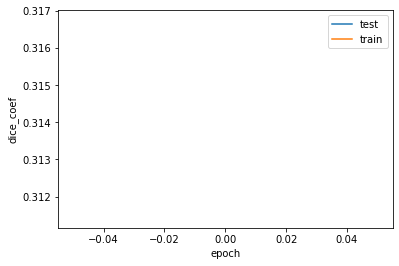

In [51]:
plt.plot(history.history['val_dice_coef'], label = 'test')
plt.plot(history.history['dice_coef'], label = 'train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [52]:
#run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = False)

In [53]:
xTest.shape

(30, 200, 400, 3)

In [54]:
pred = modelC.predict(xTest[:11], batch_size=1)
print(pred.shape)

(11, 200, 400, 16)


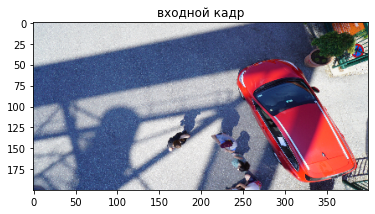

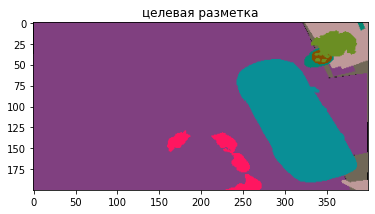

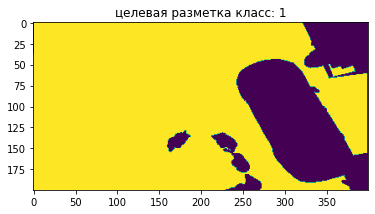

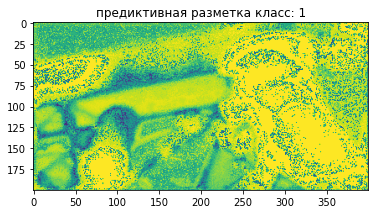

In [55]:
n = 1
class_ = 1#1#8#15
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

<h2>Вывод<h2/>

<p>После тренировки Unet на датасете было выявлено, что сеть может достигнуть 20% точности. Было дабавлено изменение в линиях объединеня сверточне слои с тангенсойдными и релу функциями. Это дало возможность достичь 38.8% точности предсказания. Также было дабавлены дополнительные релу сверточные слои и увеличино количество нейронов в 4 блоке.<p/>

<p>Много времени ушло на определение проблемы в работе TF 2.7 в сверточных сетях. Для борьбы с переполнением GPU памяти из-за проблем отчистки неиспользуемых данных необохдимо вызывать gc.collect()<p/>

<p>Данные были использованы в при уменьшении с 4000х6000 к 200х400. И при испольовании при тренировки 100 примеров при тренировки<p/>

<p>2. *Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview<p/>